In [2]:
import pandas as pd
import pickle
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from collections import Counter

import numpy as np
import spacy
from string import punctuation
from faker import Faker

In [3]:
df = pd.read_pickle('C:/Saravana/Data/Raw/export-cleansed-4851f054c66579780503d70880731802.pkl.bz2')

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
display(df.head())

,IMP_ID,GJ,IMPORT,MUFO_REFERENZ_N,BARCODE_NR,VERANST_SEGMENT,REKLA_JN,VG_DATUM_VON,VG_ORT,VG_RAUM,NUTZFALL,NUTZFALL_RAUM,MUSIKLEITER_NAME,KAPELLE_NAME,TARIF_NR,TARIF_BEZ,NUTZFALL_NR,VG_INKASSO,INKASSO_NETTO,INKASSO_BRUTTO,VERANST_GESCHAEFTSZEICHEN,VERANST_NAME,VERANST_STRASSE,VERANST_PLZ,VERANST_ORT,NUTZLIZNEHM_GESCHAEFTSZEICHEN,NUTZLIZNEHM_NAME,NUTZLIZNEHM_VORNAME,NUTZLIZNEHM_STRASSE,NUTZLIZNEHM_PLZ,NUTZLIZNEHM_ORT,LOCATION,BAND,PROMOTER
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9938765,24643,2016,ABRE U INKA 2016,NaN,5027961220,4.0,NONRekla,2014-02-09,LISBERG,TURNHALLE SV RW LISBERG,20140209.0,TURNHALLE SV RW LISBERG,NaN,NaN,892,U-K (MUSIKER),18293163,140.0,NaN,NaN,1035530900,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V,SCHINDHOLZWEG 17,96194,WALSDORF,1510423300,BAYERISCHER BLASMUSIKVERBAND,NaN,NaN,80084,MUENCHEN,LISBERG TURNHALLE SV RW LISBERG,NaN,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V 96194
9938766,24643,2016,ABRE U INKA 2016,NaN,5027961235,6.0,NONRekla,2014-02-08,LISBERG,TURNHALLE SV RW LISBERG,20140208.0,TURNHALLE SV RW LISBERG,STAERK REINHOLD,DAS BOEHMISCHE FEUER,892,U-K (MUSIKER),18293091,210.0,NaN,NaN,1035530900,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V,SCHINDHOLZWEG 17,96194,WALSDORF,1510423300,BAYERISCHER BLASMUSIKVERBAND,NaN,NaN,80084,MUENCHEN,LISBERG TURNHALLE SV RW LISBERG,DAS BOEHMISCHE FEUER,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V 96194
9938851,24643,2016,ABRE U INKA 2016,NaN,5044481411,3.0,NONRekla,2014-03-15,MUENCHEN,WERNER-VON-SIEMENS-SCHULZENTRUM,20140315.0,WERNER-VON-SIEMENS-SCHULZENTRUM,NaN,NaN,974,U-K (MUSIKER) MINDESTVERGUETUNG,18483465,72.5,NaN,NaN,2000179545,BLASORCHESTER ST. MICHAEL MUENCHEN-PERLACH E.V,HOCHAECKERSTR. 123,81737,MUENCHEN,1510423300,BAYERISCHER BLASMUSIKVERBAND,NaN,NaN,80084,MUENCHEN,MUENCHEN WERNER-VON-SIEMENS-SCHULZENTRUM,NaN,BLASORCHESTER ST. MICHAEL MUENCHEN-PERLACH E.V...
9938852,24643,2016,ABRE U INKA 2016,NaN,5044481427,2.0,NONRekla,2014-03-14,MUENCHEN,PFARRHEIM UND KIRCHE,20140314.0,PFARRHEIM UND KIRCHE,NaN,NaN,974,U-K (MUSIKER) MINDESTVERGUETUNG,18483423,34.8,NaN,NaN,2000179545,BLASORCHESTER ST. MICHAEL MUENCHEN-PERLACH E.V,HOCHAECKERSTR. 123,81737,MUENCHEN,1510423300,BAYERISCHER BLASMUSIKVERBAND,NaN,NaN,80084,MUENCHEN,MUENCHEN PFARRHEIM UND KIRCHE,NaN,BLASORCHESTER ST. MICHAEL MUENCHEN-PERLACH E.V...
9938853,24643,2016,ABRE U INKA 2016,NaN,5044481469,2.0,NONRekla,2014-02-09,GRAFENRHEINFELD,KULTURHALLE GRAFENRHEINFELD,20140209.0,KULTURHALLE GRAFENRHEINFELD,NaN,NaN,892,U-K (MUSIKER),18184927,34.8,NaN,NaN,1023588500,MUSIKVEREIN WERNECK E.V,VON-FECHENBACH-STR. 27,97440,WERNECK,1510423300,BAYERISCHER BLASMUSIKVERBAND,NaN,NaN,80084,MUENCHEN,GRAFENRHEINFELD KULTURHALLE GRAFENRHEINFELD,NaN,MUSIKVEREIN WERNECK E.V 97440


In [6]:
df.VERANST_SEGMENT.unique()

array([ 4.,  6.,  3.,  2.,  5.,  7.,  8., 10.,  9., 11., 12.])

In [7]:
len(df.index)

3296137

In [8]:
# Convert all the event segments > 3 to a event segment - 4
df.loc[df['VERANST_SEGMENT'] > 3, 'VERANST_SEGMENT'] = 4

In [9]:
# Filter segment 2(0-50 euros) & segment 3(50-100 euros) & segment 4(>100 euros)
allclaims_df = df.query('VERANST_SEGMENT <= 4')
len(allclaims_df.index)

3296137

### Unique values

In [10]:
print('Unique bands: ',len(df.BAND.unique()))
print('Unique locations: ',len(df.VG_ORT.unique()))
print('Unique venues: ',len(df.VG_RAUM.unique()))
print('Unique Promoters: ',len(df.PROMOTER.unique()))
print('Unique tariffs: ',len(df.TARIF_BEZ.unique()))

Unique bands:  329380
Unique locations:  12090
Unique venues:  129572
Unique Promoters:  243003
Unique tariffs:  91


### Visualize missing data

In [11]:
missing_data_in_df = pd.DataFrame(
    {
        "Attributes": ["imp_id", "gj", "import", "mufo_referenz_n", "barcode_nr", "veranst_segment", "rekla_jn", "vg_datum_von", "vg_ort",
                      "vg_raum", "nutzfall", "nutzfall_raum", "musikleiter_name", "kapelle_name", "tarif_nr", "tarif_bez", 
                      "nutzfall_nr", "vg_inkasso", "inkasso_netto", "inkasso_brutto", "veranst_geschaeftszeichen", "veranst_name",
                      "veranst_strasse", "veranst_plz", "veranst_ort", "nutzliznehm_geschaeftszeichen", "nutzliznehm_name", "nutzliznehm_vorname",
                      "nutzliznehm_strasse", "nutzliznehm_plz", "nutzliznehm_ort", "location", "band", "promoter"], 
        "missing (in million(s))": [0, 0, 0, 3205313, 0, 0, 0, 0, 222, 155, 0, 151, 2104917, 1477728, 0, 0, 0, 0, 2933130, 2933130, 0, 121, 20393, 
                    1225, 697, 0, 1038426, 2941456, 1052479, 1038887, 1038426, 151, 1453088, 121],
    }
)

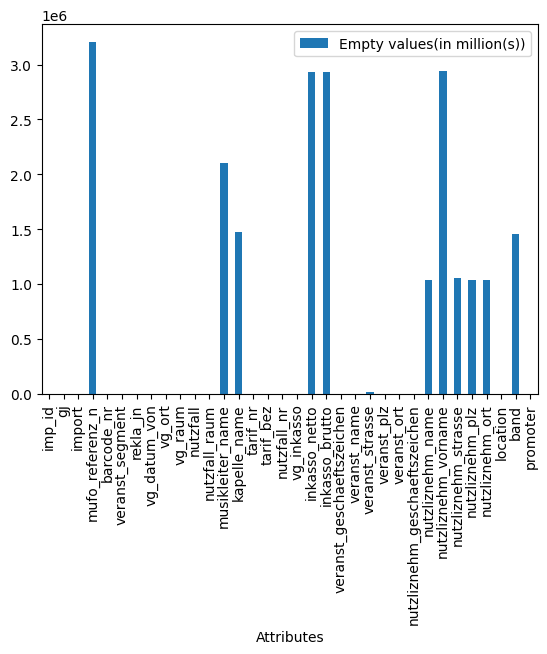

In [12]:
_, ax = plt.subplots()
missing_data_in_df.plot.bar(x="Attributes", ax= ax)
ax.legend(["Empty values(in million(s))"])

## Class distribution plot  

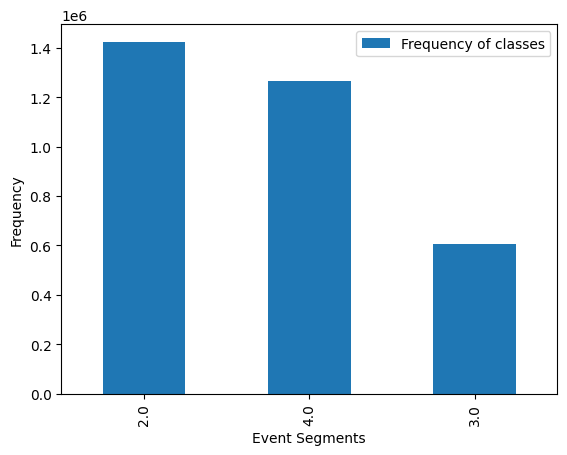

In [13]:
fig, ax = plt.subplots()

# fads = allclaims_df.copy()
# fads.rename(columns = {'test':'TEST'}, inplace = True)

allclaims_df.VERANST_SEGMENT.value_counts().plot(ax=ax, kind='bar', xlabel='Event Segments', ylabel='Frequency')
# ax.legend(["2.0 - Class 0(0-50€)", "3.0 - Class 1(50€-100€)", "4.0 - Class 2(>100€)"])
# ax.legend(["3.0 - Class 1(50€-100€)"])
# ax.legend(["4.0 - Class 2(>100€)"])
ax.legend(['Frequency of classes'])
plt.show()

## Remove missing 

Remove missing values from VG_ORT

In [14]:
allclaims_df = allclaims_df[allclaims_df['VG_ORT'].isnull()==False]
len(allclaims_df.index)

3295915

Remove missing values from BAND

In [15]:
allclaims_df = allclaims_df[allclaims_df['BAND'].isnull()==False]
len(allclaims_df.index)

1842904

Remove missing values from PROMOTER

In [16]:
allclaims_df = allclaims_df[allclaims_df['PROMOTER'].isnull()==False]
len(allclaims_df.index)

1842855

In [17]:
print('Unique locations: ',len(allclaims_df.VG_ORT.unique()))

Unique locations:  11323


In [ ]:
# IMP_ID                                 
# GJ                               GeschäftsJahr      
# IMPORT                           Distribution where the data came from      
# MUFO_REFERENZ_N                  
# BARCODE_NR                             
# VERANST_SEGMENT                  Event segment
# REKLA_JN                         Reclamation 

# VG_DATUM_VON                     Event Date
# VG_ORT                           Event place
# VG_RAUM                          Event room

# NUTZFALL                         Usage of event  
# NUTZFALL_RAUM                    Usage Room or Music hall where the music is used

# MUSIKLEITER_NAME                 Music Leader name
# KAPELLE_NAME                     Chapel name

# TARIF_NR                         Tariff Number
# TARIF_BEZ                        Tariff Bez
# NUTZFALL_NR                      Usecase Number

# VG_INKASSO                       Event collection
# INKASSO_NETTO                    Net-Collection
# INKASSO_BRUTTO                   Gross-Collection
# VERANST_GESCHAEFTSZEICHEN        Event business sign or mark 
# VERANST_NAME                     Event name
# VERANST_STRASSE                  Event street
# VERANST_PLZ                      Event post code
# VERANST_ORT                      Event place

# # Nutzungs Lizenznehmer - someone who has got the license(Usage licence) for the music works
# NUTZLIZNEHM_GESCHAEFTSZEICHEN    
# NUTZLIZNEHM_NAME                 name of person who aquired usage license
# NUTZLIZNEHM_VORNAME              surname of person who aquired usage license
# NUTZLIZNEHM_STRASSE              street of person who aquired usage license
# NUTZLIZNEHM_PLZ                  postcode of person who aquired usage license
# NUTZLIZNEHM_ORT                  place of person who aquired usage license

# LOCATION                         location - VG_ORT + VG_RAUM
# BAND                             band - KAPELLE_NAME and empty rows of kapelle name is filled with MUSIKLEITER_NAME
# PROMOTER                         promoter - VERANST_NAME + VERANST_PLZ

# VG_RAUM = 'IM FREIEN'(In Outside) or Name of the City


## Scrapping German Cities and States from Wikipedia

In [18]:
import requests
from bs4 import BeautifulSoup as bs

In [19]:
# Load the webpage
r = requests.get("https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_Germany")

# Convert the webpage content to soup object
webpage = bs(r.content)

Remove special characters and convert to uppercase

In [20]:
def remove_special_char_convert_to_uppercase(text):
    each = text.replace('ß','SS')
    each = each.upper()
    each = each.replace('Ä', 'AE')
    each = each.replace('Ö', 'OE')
    each = each.replace('Ü', 'UE')
    return each

In [21]:
c_names = ["City", "State"]
l = []
for i in range(0,25):
    table = webpage.select("table")[i]
    list = table.select("li")
    for c in list:
        each = remove_special_char_convert_to_uppercase(c.get_text(','))
        texts = each.split(',')
        city = texts[0]
        if city == 'MUNICH': city = 'MUENCHEN'
        if city == 'COLOGNE': city = 'KOELN' 
        if city == 'NUREMBERG': city = 'NUERNBERG'
        if city == 'HANOVER': city = 'HANNOVER'
         
        state = texts[1].replace('(','').replace(')','')
        l.append([city , state])
print(l[0])

['AACH', ' BADEN-WUERTTEMBERG']


In [23]:
cities_states_de_df = pd.DataFrame(l, columns=c_names)
cities_states_de_df.head()

,City,State
0,AACH,BADEN-WUERTTEMBERG
1,AACHEN,NORTH RHINE-WESTPHALIA
2,AALEN,BADEN-WUERTTEMBERG
3,ABENBERG,BAVARIA
4,ABENSBERG,BAVARIA


In [25]:
cities_states_de_df[cities_states_de_df['City']=='KOELN']

,City,State
347,KOELN,NORTH RHINE-WESTPHALIA


VG_ORT

In [26]:
# Some VG_ORT values contains of format-1:<cityname, specific region name>
# Replace all the places containing of format-1 with cityname
allPlaces=allclaims_df['VG_ORT'].tolist()
place_indicies_with_comma = [i for i in range(len(allPlaces)) if ',' in allPlaces[i]]

iter_index = 0
for each_index in allclaims_df.index[allclaims_df['VG_ORT'].str.contains(',') == True].tolist():
    cityname = allclaims_df.at[each_index, 'VG_ORT'].split(r",")[0]
    allPlaces[place_indicies_with_comma[iter_index]] = cityname
    iter_index += 1

allclaims_df['VG_ORT'] = pd.Categorical(allPlaces, ordered = False)

len(allclaims_df[allclaims_df['VG_ORT'].str.contains(',') == True])

0

Matching the state for each city or town (location) in VG_ORT

In [27]:
allclaims_df['vg_state'] = ''

In [28]:
for each in cities_states_de_df.itertuples() :
    city = each.City
    state = each.State
    allclaims_df.loc[allclaims_df['VG_ORT'] == city, 'vg_state'] = state.strip()


Load the Municipality and states in Germany that are scraped from WikiData

In [29]:
wiki_municipality_df = pd.read_csv('C:/Saravana/Projects/Intellizenz/intellizenz-model-training/data/submunicipality_municipality_district_state_germany_v3.csv')
wiki_municipality_df[['stateLabel','municipalityLabel','submunicipalityLabel']]

,stateLabel,municipalityLabel,submunicipalityLabel
0,Baden-Württemberg,Bad Urach,Bad Urach
1,Baden-Württemberg,Geislingen an der Steige,Weiler ob Helfenstein
2,Baden-Württemberg,Schramberg,Sulgen
3,Baden-Württemberg,Triberg im Schwarzwald,Triberg im Schwarzwald
4,Baden-Württemberg,Baiersbronn,Klosterreichenbach
...,...,...,...
35902,Thuringia,Frohnsdorf,NaN
35903,Bavaria,Osterberg,NaN
35904,Thuringia,Windischleuba,NaN
35905,Bavaria,Schirnding,NaN


In [30]:
for each in wiki_municipality_df.itertuples() :
    municipality = remove_special_char_convert_to_uppercase(each.municipalityLabel)
    state = remove_special_char_convert_to_uppercase(each.stateLabel)
    submunicipality = remove_special_char_convert_to_uppercase(str(each.submunicipalityLabel))
    allclaims_df.loc[allclaims_df['VG_ORT'] == municipality, 'vg_state'] = state.strip()
    allclaims_df.loc[allclaims_df['VG_ORT'] == submunicipality, 'vg_state'] = state.strip()

In [32]:
# Checking the empty values in vg_state column
empty_vg_state = allclaims_df[allclaims_df['vg_state'] == '']
print(len(empty_vg_state))
print('Unique : {}'.format(len(empty_vg_state.VG_ORT.unique())))

100658
Unique : 2367


## Remove empty values from vg_state

In [33]:
allclaims_df = allclaims_df[allclaims_df['vg_state'] != '']
len(allclaims_df.index)

1742197

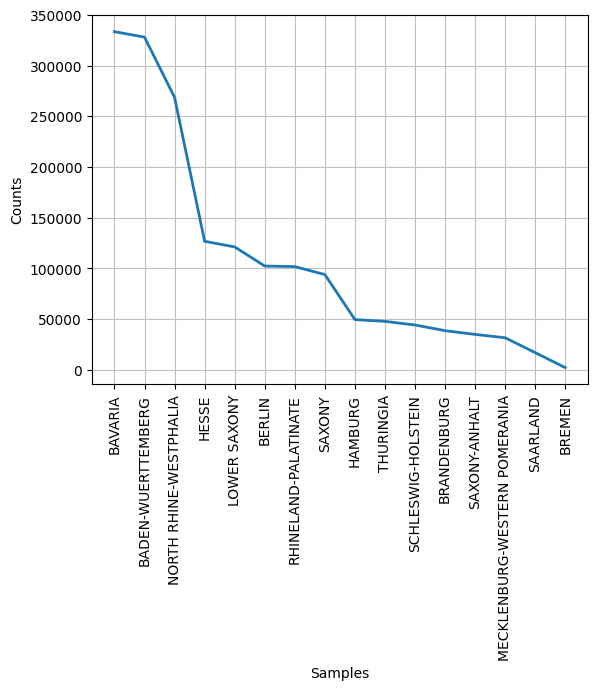

<AxesSubplot: xlabel='Samples', ylabel='Counts'>

In [34]:
flat_list_vg_state = [item for item in allclaims_df['vg_state']]
fdist_vg_state = FreqDist(flat_list_vg_state)
fdist_vg_state.plot(cumulative=False)

## Visualize the percentage of events in different states


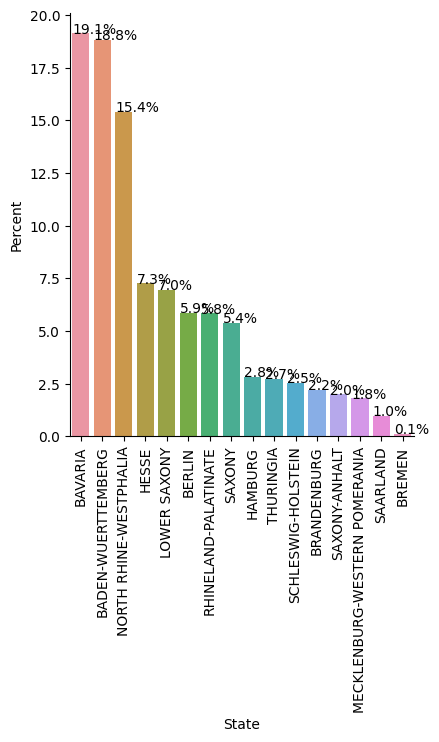

In [35]:
state_categories_df = allclaims_df['vg_state'].value_counts(normalize=True)
state_categories_df = state_categories_df.mul(100).rename('Percent').reset_index()
state_categories_df.rename(columns = {'index':'State'}, inplace = True)

g = sns.catplot(x='State', y='Percent', kind='bar', data=state_categories_df)
g.ax.tick_params(axis='x', rotation=90)

for p in g.ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

## Retreive the states, where event takes place - Featurize vg_state

In [36]:
all_states = [i[0] for i in fdist_vg_state.items()] 
df_featurize_vg_state = pd.DataFrame(allclaims_df['vg_state'])

for term in all_states :
    df_featurize_vg_state['state_'+term.lower()]=df_featurize_vg_state['vg_state'].apply(lambda x: 1 if term in x else 0)

display(df_featurize_vg_state.head(10))

,vg_state,state_bavaria,state_thuringia,state_baden-wuerttemberg,state_rhineland-palatinate,state_brandenburg,state_berlin,state_lower saxony,state_schleswig-holstein,state_hamburg,state_hesse,state_saarland,state_north rhine-westphalia,state_saxony-anhalt,state_saxony,state_mecklenburg-western pomerania,state_bremen
ID,,,,,,,,,,,,,,,,,
9938766,BAVARIA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939272,THURINGIA,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939279,BAVARIA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939280,BAVARIA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939281,BAVARIA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939282,BAVARIA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939283,BAVARIA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939284,BAVARIA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939289,BAVARIA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Featurize TARIF_BEZ


In [37]:
print('Unique Tarif: ', len(allclaims_df['TARIF_BEZ'].unique()))

Unique Tarif:  87


In [38]:
flat_list_tarif_desc = [item for item in allclaims_df['TARIF_BEZ']]
fdist_tarif_desc = FreqDist(flat_list_tarif_desc)

In [39]:
most_common_terms_tarif = [i[0] for i in fdist_tarif_desc.most_common(30)] 
df_featurize_tarif = pd.DataFrame(allclaims_df['TARIF_BEZ'])

for term in most_common_terms_tarif :
    df_featurize_tarif['tarif_'+term.lower()]=df_featurize_tarif['TARIF_BEZ'].apply(lambda x: 1 if term in x else 0)

display(df_featurize_tarif.head(10))

,TARIF_BEZ,tarif_u-v ii. 1 (+ii 2),tarif_u-k (musiker),tarif_u-k (musiker) mindestverguetung,tarif_u-st i. (musiker),tarif_u-k i (+ ii 2b) - mit sonstigem geldwerten vorteil,tarif_u-st i (musiker) nl,tarif_u-v iii. 1,tarif_u-v iii. 2,tarif_u-k iii. 2d) (musiker) - vor geladenen gaesten,tarif_variete i (musiker),tarif_u-v vi. b,tarif_e (musiker),tarif_p-k i. (u-musik),tarif_u-k ii. (musiker) bis 50 min,tarif_u-k ii. (musiker) bis 20 min,tarif_e-p,tarif_u-k ii. (musiker) bis 25 min,tarif_u-k ii. (musiker) bis 15 min,tarif_u-k ii. (musiker) bis 30 min,tarif_u-k ii. (musiker) bis 10 min,tarif_u-st (musiker),tarif_chorverband konzert u-musik,tarif_vk i 3 zirkusunternehmen (musiker),tarif_u-k ii. (musiker) bis 5 min,tarif_u-k ii. (musiker) bis 35 min,tarif_u-k ii. (musiker) bis 40 min,tarif_p-k i. (e-musik),tarif_u-k ii (musiker) mindestverguetung,tarif_u-k ii. (musiker) bis 45 min,tarif_u-v vi. b mindestverguetung
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9938766,U-K (MUSIKER),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939272,U-V II. 1 (+II 2),1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939279,U-V II. 1 (+II 2),1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939280,U-V II. 1 (+II 2),1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939281,U-V II. 1 (+II 2),1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939282,U-K (MUSIKER),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939283,U-V II. 1 (+II 2),1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939284,U-V II. 1 (+II 2),1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939289,U-V II. 1 (+II 2),1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


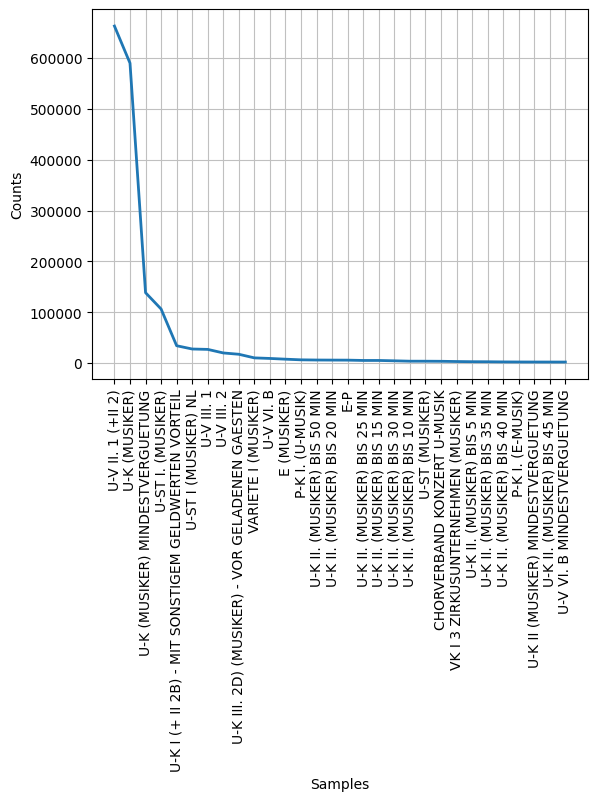

<AxesSubplot: xlabel='Samples', ylabel='Counts'>

In [40]:
fdist_tarif_desc.plot(30,cumulative=False)

### Group the frequent tariffs and rest of the tarifs to 'Other'

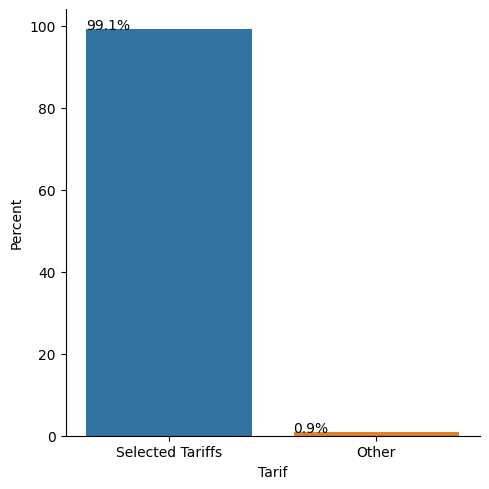

In [41]:
df_featurize_tarif['grouped_tarif']=df_featurize_tarif['TARIF_BEZ'].apply(lambda x: 'Selected Tariffs' if x in most_common_terms_tarif else 'Other')

tarif_categories_df = df_featurize_tarif['grouped_tarif'].value_counts(normalize=True)
tarif_categories_df = tarif_categories_df.mul(100).rename('Percent').reset_index()
tarif_categories_df.rename(columns = {'index':'Tarif'}, inplace = True)

g = sns.catplot(x='Tarif', y='Percent', kind='bar', data=tarif_categories_df)

for p in g.ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

## Anonymization

In [87]:
faker = Faker(['de_DE'])
Faker.seed(0)

### Visualize anonymized Band

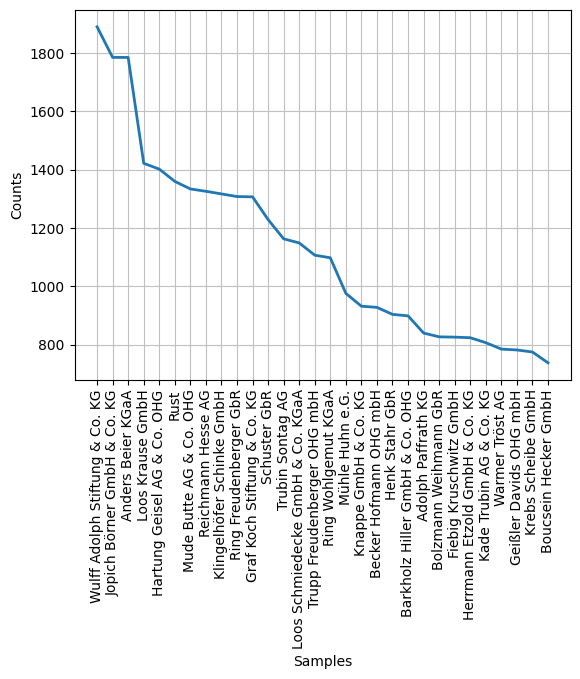

<AxesSubplot: xlabel='Samples', ylabel='Counts'>

In [65]:
flat_list_fake_bands = [item for item in allclaims_df['anonymized_band']]
fdist_fake_band = FreqDist(flat_list_fake_bands)
fdist_fake_band.plot(30,cumulative=False)

## Featurize Promoter

### Clean Promoter values; promoter_clean

In [72]:
df_featurize_promoter = pd.DataFrame(allclaims_df['PROMOTER'])
df_featurize_promoter["promoter_clean"] = allclaims_df['VERANST_NAME']

### Remove repeating company types from 'Promoter'. 
#### Get the frequencies of unique promoter entries until total of 1742197 counts(len of dataframe) is reached. Set remaining promoter entries to 'Other'

In [220]:
def remove_repeating_org_names(column,threshold=0.75,substrings=[],return_categories_list=True):
  #Find the threshold value using the percentage and number of instances in the column
  threshold_value=int(threshold*len(column))
  #Initialise an empty list for our new minimised categories
  categories_list=[]
  #Initialise a variable to calculate the sum of frequencies
  s=0
  #Create a counter dictionary of the form unique_value: frequency
  counts=Counter(column)

  # Loop through the category name and its corresponding frequency after sorting the categories by descending order of frequency
  for i,j in counts.most_common():
    #Add the frequency to the global sum
    s+=dict(counts)[i]
    category_name = i

    for substr in substrings:
      category_name = category_name.replace('K. D. OE. R','K.D.OE.R')
      if category_name.count(substr) == 2:
          category_name = category_name.replace(substr,'X',1) # replace 1st occurance of the string with X
          category_name = category_name.replace(substr,'').strip() # replace 2st occurance of the string with empty
          category_name = category_name.replace('X', substr) # replace X with substring value

    #Append the category name to the list
    categories_list.append(category_name)
    #Check if the global sum has reached the threshold value, if so break the loop
    if s>=threshold_value:
      break

  # Append the category Other to the list
  categories_list.append('Other')

  #Replace all instances not in our new categories by Other  
  new_column=column.apply(lambda x: x if x in categories_list else 'Other')

  
  #Return transformed column and unique values if return_categories=True
  if(return_categories_list):
    return new_column,categories_list
  #Return only the transformed column if return_categories=False
  else:
    return new_column

In [ ]:
org_strings = ['GMBH & CO. KG', 'E.V', 'GMBH', 'GBR', 'K.D.OE.R', 'OHG']
tran_new_column,new_cat_list=remove_repeating_org_names(df_featurize_promoter['promoter_clean'],threshold=1.00,substrings=org_strings,return_categories_list=True)

In [ ]:
tran_new_column.describe

### Transform the Promoter column to remove repetitive company name

In [73]:
# Remove the repeating organisation(company types) substring from Organizer/Promoter
def transform_promoter(x, substrings):
    str_value = x
    str_value = str_value.replace('K. D. OE. R','K.D.OE.R')

    # y = lambda substrings, str_value: (subs if(str_value.count(subs)==2) else ''  for subs in substrings)
    # result_sub_str = y(substrings, str_value)

    for subs in substrings:
        if str_value.count(subs) == 2:
            str_value = str_value.replace(subs,'X',1) # replace 1st occurance of the string with X
            str_value = str_value.replace(subs,'').strip() # replace 2st occurance of the string with empty
            str_value = str_value.replace('X', subs) # replace X with substring value
            return str_value
        else:
            return str_value

In [74]:
orgs = ['GMBH & CO. KG', 'E.V', 'GMBH', 'GBR', 'K.D.OE.R', 'OHG']

df_featurize_promoter['promoter_transform'] = df_featurize_promoter.apply(lambda x: transform_promoter(x['promoter_clean'], substrings=[orgs[0]]), axis=1)
df_featurize_promoter['promoter_transform'] = df_featurize_promoter.apply(lambda x: transform_promoter(x['promoter_transform'], substrings=[orgs[1]]), axis=1)
df_featurize_promoter['promoter_transform'] = df_featurize_promoter.apply(lambda x: transform_promoter(x['promoter_transform'], substrings=[orgs[2]]), axis=1)
df_featurize_promoter['promoter_transform'] = df_featurize_promoter.apply(lambda x: transform_promoter(x['promoter_transform'], substrings=[orgs[3]]), axis=1)
df_featurize_promoter['promoter_transform'] = df_featurize_promoter.apply(lambda x: transform_promoter(x['promoter_transform'], substrings=[orgs[4]]), axis=1)
df_featurize_promoter['promoter_transform'] = df_featurize_promoter.apply(lambda x: transform_promoter(x['promoter_transform'], substrings=[orgs[5]]), axis=1)

In [75]:
allclaims_df['promoter_transform'] = df_featurize_promoter['promoter_transform']

## Anonymize Promoter

In [88]:
dict_promoters = {promoter: faker.unique.company() for promoter in allclaims_df['promoter_transform'].unique()}
allclaims_df['anonymized_promoter'] = allclaims_df['promoter_transform'].map(dict_promoters)

### Check the distribution of promoter and Anonymized promoter

In [89]:
print('Actual unique promoters: ', len(allclaims_df['promoter_transform'].unique()))
print('Anonymized unique promoters: ', len(allclaims_df['anonymized_promoter'].unique()))

Actual unique promoters:  164542
Anonymized unique promoters:  164542


### Visualize Anonymized Promoter

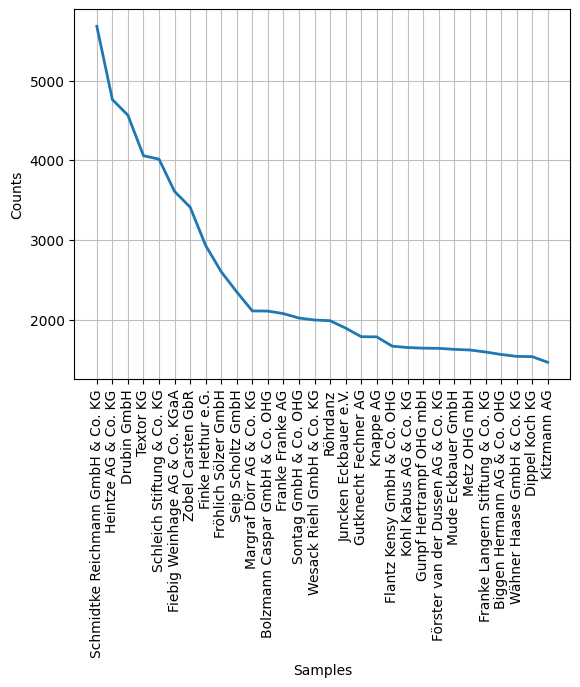

<AxesSubplot: xlabel='Samples', ylabel='Counts'>

In [91]:
flat_list_fake_promoters = [item for item in allclaims_df['anonymized_promoter']]
fdist_fake_promoter = FreqDist(flat_list_fake_promoters)
fdist_fake_promoter.plot(30,cumulative=False)

### Visualize Actual Promoter

In [96]:
# flat_list_actual_promoters = [item for item in df_featurize_promoter['promoter_transform']]
# fdist_actual_promoter = FreqDist(flat_list_actual_promoters)
# fdist_actual_promoter.plot(30,cumulative=False)

### Group the frequent promoters and rest of the promoters to 'Other'

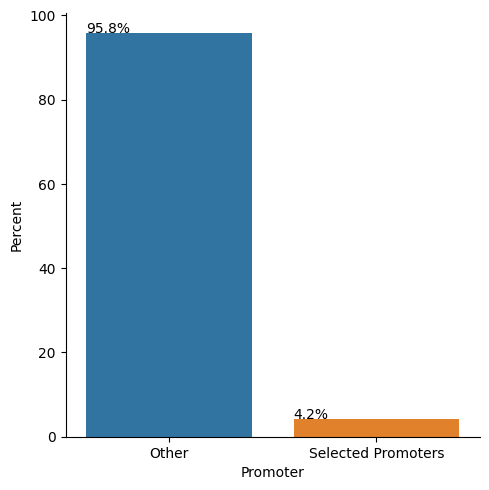

In [97]:
# most_common_terms_promoter = [i[0] for i in fdist_actual_promoter.most_common(30)]
most_common_terms_promoter = [i[0] for i in fdist_fake_promoter.most_common(30)]


df_featurize_promoter['grouped_promoter']=df_featurize_promoter['promoter_transform'].apply(lambda x: 'Selected Promoters' if x in most_common_terms_promoter else 'Other')

promoter_categories_df = df_featurize_promoter['grouped_promoter'].value_counts(normalize=True)
promoter_categories_df = promoter_categories_df.mul(100).rename('Percent').reset_index()
promoter_categories_df.rename(columns = {'index':'Promoter'}, inplace = True)

g = sns.catplot(x='Promoter', y='Percent', kind='bar', data=promoter_categories_df)

for p in g.ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

In [373]:
# condition = df_featurize_promoter['promoter_clean']!='Other'

In [100]:
df_featurize_promoter['anonymized_promoter'] = allclaims_df['anonymized_promoter'] 
df_featurize_promoter

,PROMOTER,promoter_clean,promoter_transform,grouped_promoter,anonymized_promoter
ID,,,,,
9938766,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V 96194,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V,Other,Wiek Löchel AG
9939272,WIPPERDORFER CARNEVAL CLUB E.V 99752,WIPPERDORFER CARNEVAL CLUB E.V,WIPPERDORFER CARNEVAL CLUB E.V,Other,Peukert Neuschäfer GmbH
9939279,BAYERISCHE MOTORENWERKE AG 84130,BAYERISCHE MOTORENWERKE AG,BAYERISCHE MOTORENWERKE AG,Other,Naser Klemt KG
9939280,MAENNERCHOR MILBERTSHOFEN-RIESENFELD E.V 81375,MAENNERCHOR MILBERTSHOFEN-RIESENFELD E.V,MAENNERCHOR MILBERTSHOFEN-RIESENFELD E.V,Other,Patberg AG & Co. KG
9939281,MAENNERCHOR MILBERTSHOFEN-RIESENFELD E.V 81375,MAENNERCHOR MILBERTSHOFEN-RIESENFELD E.V,MAENNERCHOR MILBERTSHOFEN-RIESENFELD E.V,Other,Patberg AG & Co. KG
...,...,...,...,...,...
13949320,MERGENER-HOF E.V. E.V 54290,MERGENER-HOF E.V. E.V,MERGENER-HOF E.V.,Other,Juncken Niemeier e.V.
13949324,MUSIKHOCHSCHULE MUENSTER 48151,MUSIKHOCHSCHULE MUENSTER,MUSIKHOCHSCHULE MUENSTER,Other,Hande Thanel AG & Co. KGaA
13949325,E-WERK KULTURZENTRUM GMBH GMBH 91054,E-WERK KULTURZENTRUM GMBH GMBH,E-WERK KULTURZENTRUM GMBH,Selected Promoters,Kitzmann AG


In [106]:
# flat_list_clean_promoter = [item for item in df_featurize_promoter[condition]['promoter_clean']]
flat_list_clean_promoter = [item for item in df_featurize_promoter['anonymized_promoter']]
fdist_clean_promoter = FreqDist(flat_list_clean_promoter)
most_common_terms_clean_promoter = [i[0] for i in fdist_clean_promoter.most_common(30)] 


for term in most_common_terms_clean_promoter :
    # df_featurize_promoter['promoter_'+term.lower()]=df_featurize_promoter['promoter_clean'].apply(lambda x: 1 if term in str(x) else 0)
    df_featurize_promoter['promoter_'+term.lower()]=df_featurize_promoter['anonymized_promoter'].apply(lambda x: 1 if term in str(x) else 0)

display(df_featurize_promoter.head(5))

,PROMOTER,promoter_clean,promoter_transform,grouped_promoter,anonymized_promoter,promoter_schmidtke reichmann gmbh & co. kg,promoter_heintze ag & co. kg,promoter_drubin gmbh,promoter_textor kg,promoter_schleich stiftung & co. kg,promoter_fiebig weinhage ag & co. kgaa,promoter_zobel carsten gbr,promoter_finke hethur e.g.,promoter_fröhlich sölzer gmbh,promoter_seip scholtz gmbh,promoter_margraf dörr ag & co. kg,promoter_bolzmann caspar gmbh & co. ohg,promoter_franke franke ag,promoter_sontag gmbh & co. ohg,promoter_wesack riehl gmbh & co. kg,promoter_röhrdanz,promoter_juncken eckbauer e.v.,promoter_gutknecht fechner ag,promoter_knappe ag,promoter_flantz kensy gmbh & co. ohg,promoter_kohl kabus ag & co. kg,promoter_gunpf hertrampf ohg mbh,promoter_förster van der dussen ag & co. kg,promoter_mude eckbauer gmbh,promoter_metz ohg mbh,promoter_franke langern stiftung & co. kg,promoter_biggen hermann ag & co. ohg,promoter_wähner haase gmbh & co. kg,promoter_dippel koch kg,promoter_kitzmann ag
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9938766,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V 96194,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V,Other,Wiek Löchel AG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939272,WIPPERDORFER CARNEVAL CLUB E.V 99752,WIPPERDORFER CARNEVAL CLUB E.V,WIPPERDORFER CARNEVAL CLUB E.V,Other,Peukert Neuschäfer GmbH,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939279,BAYERISCHE MOTORENWERKE AG 84130,BAYERISCHE MOTORENWERKE AG,BAYERISCHE MOTORENWERKE AG,Other,Naser Klemt KG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939280,MAENNERCHOR MILBERTSHOFEN-RIESENFELD E.V 81375,MAENNERCHOR MILBERTSHOFEN-RIESENFELD E.V,MAENNERCHOR MILBERTSHOFEN-RIESENFELD E.V,Other,Patberg AG & Co. KG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939281,MAENNERCHOR MILBERTSHOFEN-RIESENFELD E.V 81375,MAENNERCHOR MILBERTSHOFEN-RIESENFELD E.V,MAENNERCHOR MILBERTSHOFEN-RIESENFELD E.V,Other,Patberg AG & Co. KG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


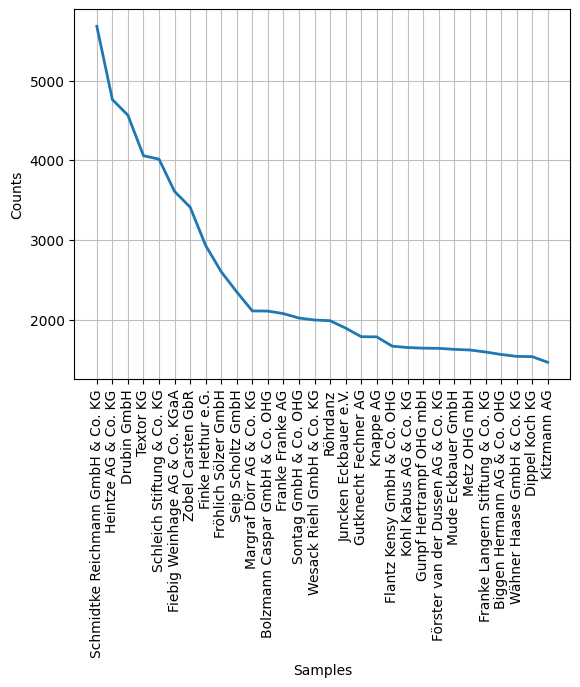

<AxesSubplot: xlabel='Samples', ylabel='Counts'>

In [107]:
fdist_clean_promoter.plot(30,cumulative=False)

In [ ]:
# google maps API
# how big the city is?
# how close the location to the city centre?

## Venues

In [44]:
nlp = spacy.load('C:/Users/sgopalakrish/Miniconda3/Lib/site-packages/de_core_news_sm/de_core_news_sm-3.4.0/')
nlp_en = spacy.load('C:/Users/sgopalakrish/Miniconda3/Lib/site-packages/en_core_web_sm/en_core_web_sm-3.4.1')

In [45]:
german_stop_words = nlp.Defaults.stop_words
english_stop_words = nlp_en.Defaults.stop_words

In [46]:
def remove_special_chars_from(stopwords):
    cleaned_stop_words = []
    for each in stopwords:
        each = each.replace('ß','SS')
        each = each.upper()
        each = each.replace('Ä', 'AE')
        each = each.replace('Ö', 'OE')
        each = each.replace('Ü', 'UE')
        
        cleaned_stop_words.append(each)
    return cleaned_stop_words

In [47]:
cleaned_de_stopwords = remove_special_chars_from(german_stop_words)

additional_stopwords = [
    'ST', 'FREIEN', 'BAD', 'HAUS', 'EV', 'BERLIN', 'KATH', 'S', 'HOF', 'ALTE', 'MITTE', 'LUTH', 'MUENCHEN',
    'IRISH', 'MUSIK', 'KULTUR', 'FUER', 'EVANG', 'MARITIM', 'KOELN', 'U', 'TURN', 'E', 'STUTTGART', 'ALTES',
    'A', 'GASTES', 'THE', 'EUROPA', 'HANNOVER', 'STADT', 'BADEN', 'NUERNBERG', 'HAMBURG', 'NEUE',
    'EVANGELISCHE', 'LEIPZIG', 'B', 'DRESDEN', 'BREMEN', 'PETER', '1','ALTER', 'AM', 'DIE', 'DER',
    'DAS', 'DES', 'DEN', 'DEM', 'EIN', 'EINER', 'EINEM', 'EINES', 'EINE',
    'MEIN', 'MEINER', 'MEINES', 'MEINEM', 'MEINE', 'UND'
]


In [48]:
en_stop_words = []
for each in english_stop_words:
    en_stop_words.append(each)

In [49]:
all_stopwords = cleaned_de_stopwords + additional_stopwords + en_stop_words
all_stopwords = [x.lower() for x in all_stopwords]
# all_stopwords = list(map(lambda x: x.lower(), all_stopwords))

In [50]:
# Find all the categories of VG_RAUM
allclaims_df['VG_RAUM_clean']=allclaims_df['VG_RAUM'].astype(str).fillna('').map(lambda x: re.sub(r'\W+', ' ', x))

In [51]:
room_list_wo_stopwords = []
for each_room in allclaims_df['VG_RAUM_clean'].tolist():
    for each_stopword in all_stopwords:
        # Remove stopword from each row in VG_RAUM_clean 
        each_room.replace(each_stopword,'')
        
    if 'KIRCHE' in each_room:
        room_list_wo_stopwords.append('KIRCHE')
    else:
        room_list_wo_stopwords.append(each_room)

In [52]:
room_list_wo_stopwords = [x.lower() for x in room_list_wo_stopwords]

In [53]:
allclaims_df['VG_RAUM_WO_STOPWORDS'] = room_list_wo_stopwords

In [54]:
# Stemming - removes suffixes and prefixes from word roots, 
# Lemmatization - maps the remaining root forms (which may not always be proper words) back to an actual word that occurs in natural language.

Get keywords using spacy

In [55]:
def get_keywords(text):
    result = []
    pos_tag = ['PROPN', 'NOUN', 'VERB']
    for token in text:
        if(token.text in all_stopwords or token.text in punctuation):
            continue
        if(token.pos_ in pos_tag):
            result.append(token.text) 
    return result

In [56]:
raum_cleaned_df = (row.VG_RAUM_WO_STOPWORDS for row in allclaims_df.itertuples())

vg_raum_keywords = []
for each_object in nlp.pipe(raum_cleaned_df):
  vg_raum_keywords.append(get_keywords(each_object))

In [57]:
allclaims_df['VG_RAUM_KEYWORDS'] = vg_raum_keywords

## Featurize VG_RAUM

In [58]:
flat_list_vg_raum_keywords = [item for sublist in allclaims_df['VG_RAUM_KEYWORDS'] for item in sublist]
fdist_vg_raum_keywords = FreqDist(flat_list_vg_raum_keywords)
most_common_terms_vg_raum = [i[0] for i in fdist_vg_raum_keywords.most_common(30)]

In [59]:
df_featurize_vg_raum_keywords = pd.DataFrame(allclaims_df['VG_RAUM_KEYWORDS'])

for term in most_common_terms_vg_raum :
    df_featurize_vg_raum_keywords['place_'+term]=df_featurize_vg_raum_keywords['VG_RAUM_KEYWORDS'].apply(lambda x: 1 if term in x else 0)

display(df_featurize_vg_raum_keywords.head(10))

,VG_RAUM_KEYWORDS,place_kirche,place_hotel,place_cafe,place_theater,place_club,place_halle,place_gaststaette,place_festhalle,place_kulturzentrum,place_festzelt,place_schloss,place_pub,place_stadthalle,place_park,place_gasthof,place_kabarett,place_arena,place_schlachthof,place_wandelhalle,place_turnhalle,place_buergerhaus,place_museum,place_rathaus,place_staatsbad,place_zelt,place_jazz,place_forum,place_gymnasium,place_schule,place_sporthalle
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9938766,"[turnhalle, sv, rw, lisberg]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9939272,"[grundschule, wipperdorf]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939279,"[bmw, werk, dingolfing]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939280,[milbertshofen],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939281,[milbertshofen],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939282,"[gaststaette, gistl]",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939283,[schuetzenheim],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939284,"[gaststaette, lustinger]",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939289,[martin],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


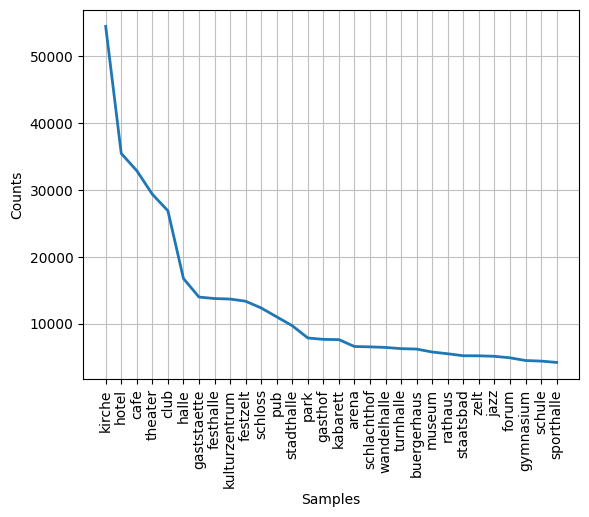

<AxesSubplot: xlabel='Samples', ylabel='Counts'>

In [60]:
fdist_vg_raum_keywords.plot(30,cumulative=False)

In [61]:
display(allclaims_df.head())

,IMP_ID,GJ,IMPORT,MUFO_REFERENZ_N,BARCODE_NR,VERANST_SEGMENT,REKLA_JN,VG_DATUM_VON,VG_ORT,VG_RAUM,NUTZFALL,NUTZFALL_RAUM,MUSIKLEITER_NAME,KAPELLE_NAME,TARIF_NR,TARIF_BEZ,NUTZFALL_NR,VG_INKASSO,INKASSO_NETTO,INKASSO_BRUTTO,VERANST_GESCHAEFTSZEICHEN,VERANST_NAME,VERANST_STRASSE,VERANST_PLZ,VERANST_ORT,NUTZLIZNEHM_GESCHAEFTSZEICHEN,NUTZLIZNEHM_NAME,NUTZLIZNEHM_VORNAME,NUTZLIZNEHM_STRASSE,NUTZLIZNEHM_PLZ,NUTZLIZNEHM_ORT,LOCATION,BAND,PROMOTER,vg_state,anonymized_band,VG_RAUM_clean,VG_RAUM_WO_STOPWORDS,VG_RAUM_KEYWORDS
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9938766,24643,2016,ABRE U INKA 2016,NaN,5027961235,4.0,NONRekla,2014-02-08,LISBERG,TURNHALLE SV RW LISBERG,20140208.0,TURNHALLE SV RW LISBERG,STAERK REINHOLD,DAS BOEHMISCHE FEUER,892,U-K (MUSIKER),18293091,210.00,NaN,NaN,1035530900,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V,SCHINDHOLZWEG 17,96194,WALSDORF,1510423300,BAYERISCHER BLASMUSIKVERBAND,NaN,NaN,80084,MUENCHEN,LISBERG TURNHALLE SV RW LISBERG,DAS BOEHMISCHE FEUER,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V 96194,BAVARIA,Hörle Stiftung & Co. KG,TURNHALLE SV RW LISBERG,turnhalle sv rw lisberg,"[turnhalle, sv, rw, lisberg]"
9939272,24643,2016,ABRE U INKA 2016,NaN,5053180236,3.0,NONRekla,2014-02-22,WIPPERDORF,STAATLICHE GRUNDSCHULE WIPPERDORF,20140222.0,STAATLICHE GRUNDSCHULE WIPPERDORF,PATSCHKE RAINER,KYFFHAEUSER TANZ BAN,1087,U-V II. 1 (+II 2),17923031,85.06,NaN,NaN,1374109400,WIPPERDORFER CARNEVAL CLUB E.V,STRASSE DER EINHEIT 6,99752,WIPPERDORF,1374109400,WIPPERDORFER CARNEVAL CLUB,NaN,STRASSE DER EINHEIT 6,99752,WIPPERDORF,WIPPERDORF STAATLICHE GRUNDSCHULE WIPPERDORF,KYFFHAEUSER TANZ BAN,WIPPERDORFER CARNEVAL CLUB E.V 99752,THURINGIA,Mitschke GmbH,STAATLICHE GRUNDSCHULE WIPPERDORF,staatliche grundschule wipperdorf,"[grundschule, wipperdorf]"
9939279,24643,2016,ABRE U INKA 2016,NaN,5053345001,3.0,NONRekla,2014-02-18,DINGOLFING,BMW-WERK DINGOLFING,20140218.0,BMW-WERK DINGOLFING,JUNDMAYER,BERUFSFACHSCHULE,1087,U-V II. 1 (+II 2),17757433,90.20,NaN,NaN,2000026695,BAYERISCHE MOTORENWERKE AG,MENGKOFENER STR. 13,84130,DINGOLFING,2000026695,BAYERISCHE MOTORENWERKE,NaN,MENGKOFENER STR. 13,84130,DINGOLFING,DINGOLFING BMW-WERK DINGOLFING,BERUFSFACHSCHULE,BAYERISCHE MOTORENWERKE AG 84130,BAVARIA,Tintzmann,BMW WERK DINGOLFING,bmw werk dingolfing,"[bmw, werk, dingolfing]"
9939280,24643,2016,ABRE U INKA 2016,NaN,5053345402,4.0,NONRekla,2014-03-29,MUENCHEN,KULTURHAUS MILBERTSHOFEN,20140329.0,KULTURHAUS MILBERTSHOFEN,SCHULLERUS WERNER,SIEBENBUERGER BLASMU,1087,U-V II. 1 (+II 2),18051337,206.12,NaN,NaN,910166400,MAENNERCHOR MILBERTSHOFEN-RIESENFELD E.V,KORNWEGERSTR. 10,81375,MUENCHEN,910166400,MAENNERCHOR MILBERTSHOFEN-RIESENFELD,NaN,KORNWEGERSTR. 10,81375,MUENCHEN,MUENCHEN KULTURHAUS MILBERTSHOFEN,SIEBENBUERGER BLASMU,MAENNERCHOR MILBERTSHOFEN-RIESENFELD E.V 81375,BAVARIA,Meyer KG,KULTURHAUS MILBERTSHOFEN,kulturhaus milbertshofen,[milbertshofen]
9939281,24643,2016,ABRE U INKA 2016,NaN,5053345418,4.0,NONRekla,2014-03-21,MUENCHEN,KULTURHAUS MILBERTSHOFEN,20140321.0,KULTURHAUS MILBERTSHOFEN,SCHULLERUS WERNER,SIEBENBUERGER BLASMU,1087,U-V II. 1 (+II 2),18051299,206.12,NaN,NaN,910166400,MAENNERCHOR MILBERTSHOFEN-RIESENFELD E.V,KORNWEGERSTR. 10,81375,MUENCHEN,910166400,MAENNERCHOR MILBERTSHOFEN-RIESENFELD,NaN,KORNWEGERSTR. 10,81375,MUENCHEN,MUENCHEN KULTURHAUS MILBERTSHOFEN,SIEBENBUERGER BLASMU,MAENNERCHOR MILBERTSHOFEN-RIESENFELD E.V 81375,BAVARIA,Meyer KG,KULTURHAUS MILBERTSHOFEN,kulturhaus milbertshofen,[milbertshofen]


### Group the frequent venues and rest of the venues to 'Other'

In [62]:
# most_common_terms_vg_raum = [i[0] for i in fdist_vg_raum_keywords.most_common(200)]

list_venue_wo_stopwords = [item for item in allclaims_df['VG_RAUM_WO_STOPWORDS']]
fdist_venue = FreqDist(list_venue_wo_stopwords)
most_common_terms_vg_raum = [i[0] for i in fdist_venue.most_common(2000)]

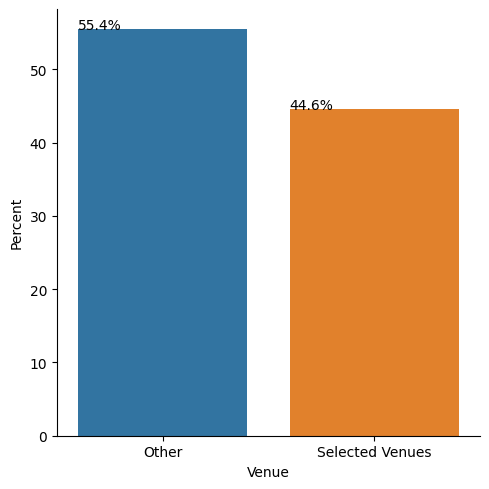

In [63]:
# for term in most_common_terms_vg_raum :
    # df_featurize_vg_raum_keywords['grouped_venue']=df_featurize_vg_raum_keywords['VG_RAUM_KEYWORDS'].apply(lambda x: 'Selected Venues' if term in x else 'Other')

df_featurize_vg_raum_keywords['grouped_venue']=allclaims_df['VG_RAUM_WO_STOPWORDS'].apply(lambda x: 'Selected Venues' if x in most_common_terms_vg_raum else 'Other') 


venue_categories_df = df_featurize_vg_raum_keywords['grouped_venue'].value_counts(normalize=True)
venue_categories_df = venue_categories_df.mul(100).rename('Percent').reset_index()
venue_categories_df.rename(columns = {'index':'Venue'}, inplace = True)

g = sns.catplot(x='Venue', y='Percent', kind='bar', data=venue_categories_df)

for p in g.ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

## Featurize BAND

### Anonymized BAND

In [103]:
dict_bands = {band: faker.unique.company() for band in allclaims_df['BAND'].unique()}
allclaims_df['anonymized_band'] = allclaims_df['BAND'].map(dict_bands)

### Check the distribution of actual band & anonymized band

In [104]:
print('Actual unique bands: ', len(allclaims_df['BAND'].unique()))
print('Anonymized unique bands: ', len(allclaims_df['anonymized_band'].unique()))

Actual unique bands:  317007
Anonymized unique bands:  317007


### Visualize anonymized Band

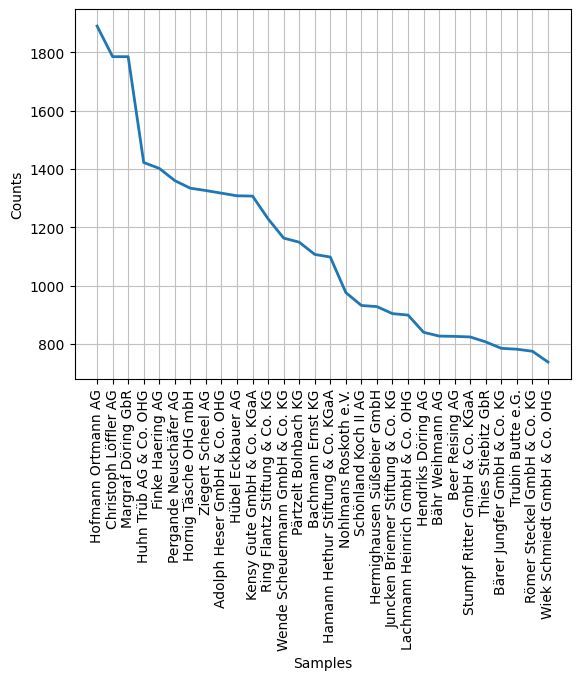

<AxesSubplot: xlabel='Samples', ylabel='Counts'>

In [105]:
flat_list_fake_bands = [item for item in allclaims_df['anonymized_band']]
fdist_fake_band = FreqDist(flat_list_fake_bands)
fdist_fake_band.plot(30,cumulative=False)

In [108]:
# flat_list_band = [item for item in allclaims_df['BAND']]
flat_list_band = [item for item in allclaims_df['anonymized_band']]
fdist_band_desc = FreqDist(flat_list_band)
most_common_terms_band = [i[0] for i in fdist_band_desc.most_common(30)] 
# df_featurize_band = pd.DataFrame(allclaims_df['BAND'])
df_featurize_band = pd.DataFrame(allclaims_df['anonymized_band'])

In [109]:
for term in most_common_terms_band :
    # df_featurize_band['band_'+term.lower()]=df_featurize_band['BAND'].apply(lambda x: 1 if term in x else 0)
    df_featurize_band['band_'+term.lower()]=df_featurize_band['anonymized_band'].apply(lambda x: 1 if term in x else 0)

display(df_featurize_band.head(10))

,anonymized_band,band_hofmann ortmann ag,band_christoph löffler ag,band_margraf döring gbr,band_huhn trüb ag & co. ohg,band_finke haering ag,band_pergande neuschäfer ag,band_hornig täsche ohg mbh,band_ziegert scheel ag,band_adolph heser gmbh & co. ohg,band_hübel eckbauer ag,band_kensy gute gmbh & co. kgaa,band_ring flantz stiftung & co. kg,band_wende scheuermann gmbh & co. kg,band_pärtzelt bolnbach kg,band_bachmann ernst kg,band_hamann hethur stiftung & co. kgaa,band_nohlmans roskoth e.v.,band_schönland koch ii ag,band_hermighausen süßebier gmbh,band_juncken briemer stiftung & co. kg,band_lachmann heinrich gmbh & co. ohg,band_hendriks döring ag,band_bähr weihmann ag,band_beer reising ag,band_stumpf ritter gmbh & co. kgaa,band_thies stiebitz gbr,band_bärer jungfer gmbh & co. kg,band_trubin butte e.g.,band_römer steckel gmbh & co. kg,band_wiek schmiedt gmbh & co. ohg
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9938766,Klapp Dehmel AG & Co. OHG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939272,Karz Ritter KGaA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939279,Klemm Ullrich OHG mbH,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939280,Albers Klemt GmbH & Co. OHG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939281,Albers Klemt GmbH & Co. OHG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939282,Süßebier Junk AG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939283,Trapp Holzapfel AG & Co. KGaA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939284,Wulf Drub GbR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939289,Röhricht Löffler AG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


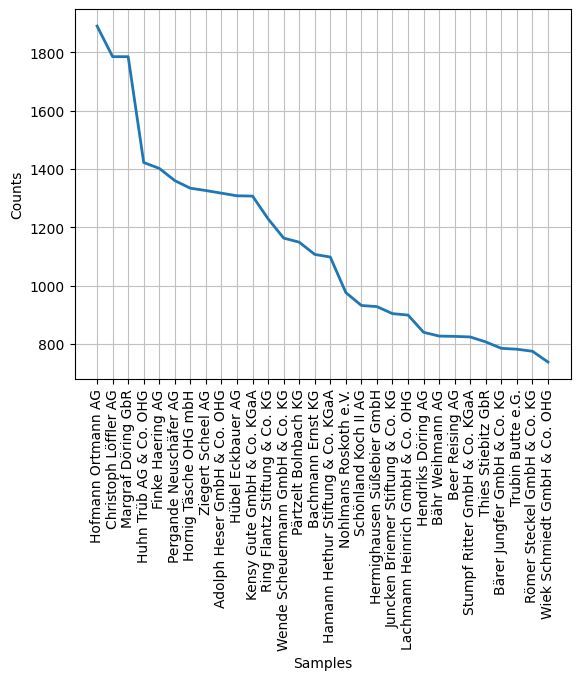

<AxesSubplot: xlabel='Samples', ylabel='Counts'>

In [110]:
fdist_band_desc.plot(30,cumulative=False)

### Group the frequent bands and rest of the bands to 'Other'

In [162]:
most_common_terms_band = [i[0] for i in fdist_band_desc.most_common(50)] 

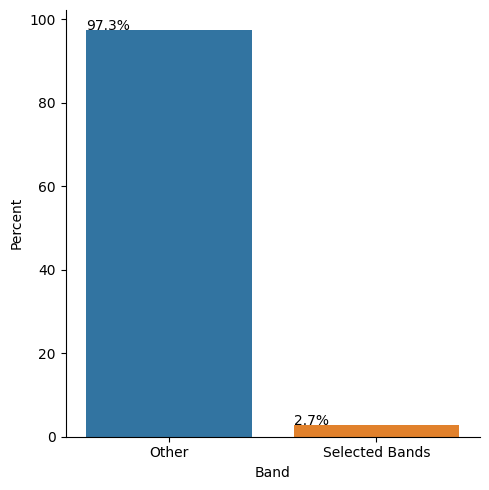

In [163]:
df_featurize_band['grouped_band']=allclaims_df['BAND'].apply(lambda x: 'Selected Bands' if x in most_common_terms_band else 'Other')

band_categories_df = df_featurize_band['grouped_band'].value_counts(normalize=True)
band_categories_df = band_categories_df.mul(100).rename('Percent').reset_index()
band_categories_df.rename(columns = {'index':'Band'}, inplace = True)

g = sns.catplot(x='Band', y='Percent', kind='bar', data=band_categories_df)

for p in g.ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

## VERANST_SEGMENT

In [111]:
from sklearn.preprocessing import LabelEncoder

In [112]:
# Convert the VERANST_SEGMENT values from float to Int
allclaims_df.VERANST_SEGMENT = allclaims_df['VERANST_SEGMENT'].astype(int)

In [113]:
le = LabelEncoder()
allclaims_df['VERANST_SEGMENT'] = le.fit_transform(allclaims_df['VERANST_SEGMENT'])

## VG_DATUM

In [114]:
allclaims_df['VG_DATUM_YEAR'] = le.fit_transform(allclaims_df['VG_DATUM_VON'].dt.year)
allclaims_df['VG_DATUM_MONTH'] = le.fit_transform(allclaims_df['VG_DATUM_VON'].dt.month)
allclaims_df['VG_DATUM_DAY_OF_WEEK']= le.fit_transform(allclaims_df['VG_DATUM_VON'].dt.dayofweek)

seasons = [0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 0]
claim_season_list = [seasons[item] for item in allclaims_df['VG_DATUM_MONTH']]

allclaims_df['VG_DATUM_SEASON'] = claim_season_list

## Correlation Heatmap

### Define a new dataframe corr_df1, that contains only venue details

In [342]:
# Replace the list of keywords with most frequest keyword
def transform_venue(x, venue):
    venue_keywords = x

    if venue in venue_keywords:
        return venue
    else:
        return venue_keywords

In [301]:
corr_df1 = allclaims_df[['VG_RAUM_KEYWORDS']].copy()

In [334]:
venue_strs = []
for keyword_list in corr_df1['VG_RAUM_KEYWORDS'].values:
    if len(keyword_list) == 0:
        venue_strs.append('')
    else:
        ad = ' '.join(e for e in keyword_list)
        venue_strs.append(ad)

In [335]:
corr_df1['venue'] = venue_strs

In [347]:
# ['kirche', 'hotel', 'cafe', 'theater', 'club', 'halle', 'gaststaette', 'festhalle', 'kulturzentrum', 'festzelt', 
# 'schloss', 'pub', 'stadthalle', 'park', 'gasthof', 'kabarett', 'arena', 'schlachthof', 'wandelhalle', 'turnhalle', 
# 'buergerhaus', 'museum', 'rathaus', 'staatsbad', 'zelt', 'jazz', 'forum', 'gymnasium', 'schule', 'sporthalle']

corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue'], 'kirche'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'hotel'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'cafe'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'theater'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'club'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'halle'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'gaststaette'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'festhalle'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'kulturzentrum'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'festzelt'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'schloss'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'pub'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'stadthalle'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'park'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'gasthof'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'kabarett'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'arena'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'schlachthof'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'wandelhalle'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'turnhalle'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'buergerhaus'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'museum'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'rathaus'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'staatsbad'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'zelt'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'jazz'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'forum'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'gymnasium'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'schule'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'sporthalle'), axis=1)

### Extract the selected features into a new dataframe corr_df, to visualize the correlation heatmap

In [380]:
feat_columns = ['VG_DATUM_YEAR','VG_DATUM_MONTH', 'VG_DATUM_DAY_OF_WEEK', 'VG_DATUM_SEASON', 'VERANST_SEGMENT', 
            'BAND', 'TARIF_BEZ', 'VG_RAUM_KEYWORDS', 'promoter_transform', 'vg_state']


corr_df = allclaims_df[feat_columns].copy()
corr_df['BAND'] = le.fit_transform(corr_df['BAND'])
corr_df['TARIF_BEZ'] = le.fit_transform(corr_df['TARIF_BEZ'])
corr_df['promoter_transform'] = le.fit_transform(corr_df['promoter_transform'])
corr_df['vg_state'] = le.fit_transform(corr_df['vg_state'])

corr_df['venue'] = corr_df1['venue_clean'].values 
corr_df['venue'] = le.fit_transform(corr_df['venue'])

feat_columns.append('venue')

In [382]:
corr_df=corr_df.rename(str.lower, axis='columns')

C:\Users\sgopalakrish\AppData\Local\Temp\ipykernel_35508\1029237510.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = corr_df[lower_feat_columns].corr()


<AxesSubplot: >

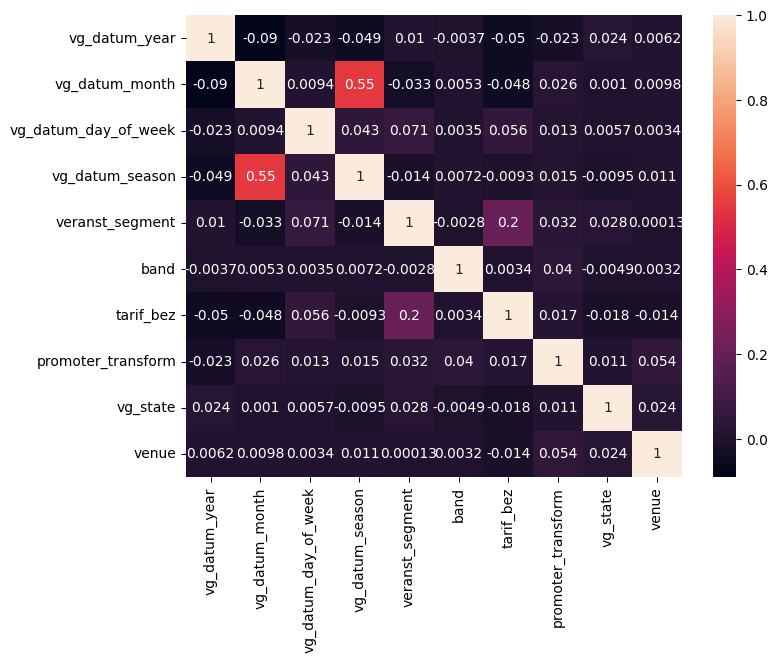

In [388]:
# Correlation between features
lower_feat_columns = [each.lower() for each in feat_columns]

corr = corr_df[lower_feat_columns].corr()
f, ax = plt.subplots(figsize=(8,6))

# Configure a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, annot=True)

## Merge all the features

In [273]:
allclaims_feature_df = allclaims_df.merge(df_featurize_vg_raum_keywords, how='left', on='ID')
allclaims_feature_df = allclaims_feature_df.merge(df_featurize_tarif, how='left', on='ID')
allclaims_feature_df = allclaims_feature_df.merge(df_featurize_vg_state, how='left', on='ID')
allclaims_feature_df = allclaims_feature_df.merge(df_featurize_band, how='left', on='ID')
allclaims_feature_df = allclaims_feature_df.merge(df_featurize_promoter, how='left', on='ID')

In [274]:
allclaims_feature_df=allclaims_feature_df.rename(str.lower, axis='columns')

In [ ]:
display(allclaims_feature_df.head(5))

In [ ]:
#allclaims_feature_df.to_pickle('./data/export_features_2016_2020_v1.pkl.bz2', protocol=4)

In [275]:
# ArrowTypeError: ("Expected bytes, got a 'float' object", 'Conversion failed for column nutzliznehm_plz with type object')
allclaims_feature_df = allclaims_feature_df.drop('nutzliznehm_plz', axis=1)

In [50]:
# allclaims_feature_df.to_parquet('./data/export_features_2016_2020_v2.parquet.gzip',compression='gzip')

In [276]:
allclaims_feature_df.to_parquet('./data/export_features_2016_2020_v3.parquet.gzip',compression='gzip')

## Get Essential anonymized columns

In [125]:
anony_columns = ['VG_RAUM_KEYWORDS', 'VG_RAUM_WO_STOPWORDS', 'VG_RAUM', 'anonymized_band', 'anonymized_promoter',
'TARIF_BEZ', 'vg_state', 'VG_ORT',
'VG_DATUM_SEASON', 'VG_DATUM_MONTH', 'VG_DATUM_DAY_OF_WEEK', 'VG_DATUM_YEAR',
'VG_DATUM_VON', 'VERANST_SEGMENT', 'VG_INKASSO']
anonymized_essential_df =  allclaims_df[anony_columns].copy()

In [126]:
anonymized_essential_df=anonymized_essential_df.rename(str.lower, axis='columns')

In [128]:
anonymized_essential_df.to_parquet('./data/export_anonymized_features_2016_2020.parquet.gzip',compression='gzip')

In [132]:
anony_df = pd.read_parquet('C:/Users/sgopalakrish/Downloads/intellizenz-model-training/data/export_anonymized_features_2016_2020.parquet.gzip')
display(anony_df.head())
print(anony_df.shape)

,vg_raum_keywords,vg_raum_wo_stopwords,vg_raum,anonymized_band,anonymized_promoter,tarif_bez,vg_state,vg_ort,vg_datum_season,vg_datum_month,vg_datum_day_of_week,vg_datum_year,vg_datum_von,veranst_segment,vg_inkasso
ID,,,,,,,,,,,,,,,
9938766,"[turnhalle, sv, rw, lisberg]",turnhalle sv rw lisberg,TURNHALLE SV RW LISBERG,Klapp Dehmel AG & Co. OHG,Wiek Löchel AG,U-K (MUSIKER),BAVARIA,LISBERG,0,1,5,0,2014-02-08,2,210.00
9939272,"[grundschule, wipperdorf]",staatliche grundschule wipperdorf,STAATLICHE GRUNDSCHULE WIPPERDORF,Karz Ritter KGaA,Peukert Neuschäfer GmbH,U-V II. 1 (+II 2),THURINGIA,WIPPERDORF,0,1,5,0,2014-02-22,1,85.06
9939279,"[bmw, werk, dingolfing]",bmw werk dingolfing,BMW-WERK DINGOLFING,Klemm Ullrich OHG mbH,Naser Klemt KG,U-V II. 1 (+II 2),BAVARIA,DINGOLFING,0,1,1,0,2014-02-18,1,90.20
9939280,[milbertshofen],kulturhaus milbertshofen,KULTURHAUS MILBERTSHOFEN,Albers Klemt GmbH & Co. OHG,Patberg AG & Co. KG,U-V II. 1 (+II 2),BAVARIA,MUENCHEN,1,2,5,0,2014-03-29,2,206.12
9939281,[milbertshofen],kulturhaus milbertshofen,KULTURHAUS MILBERTSHOFEN,Albers Klemt GmbH & Co. OHG,Patberg AG & Co. KG,U-V II. 1 (+II 2),BAVARIA,MUENCHEN,1,2,4,0,2014-03-21,2,206.12


(1742197, 15)


In [133]:
target_encoded_df = pd.read_parquet('C:/Users/sgopalakrish/Downloads/intellizenz-model-training/data/export_features_2016_2020_v5.parquet.gzip')
display(target_encoded_df.head())
print(target_encoded_df.shape)

,venue_10%,venue_15%,venue_20%,venue_25%,venue_30%,venue_35%,venue_40%,venue_45%,venue_5%,venue_50%,venue_55%,venue_60%,venue_65%,venue_70%,venue_75%,venue_80%,venue_85%,venue_90%,venue_95%,venue_count,venue_max,venue_mean,venue_min,venue_std,band_10%,band_15%,band_20%,band_25%,band_30%,band_35%,band_40%,band_45%,band_5%,band_50%,band_55%,band_60%,band_65%,band_70%,band_75%,band_80%,band_85%,band_90%,band_95%,band_count,band_max,band_mean,band_min,band_std,promoter_10%,promoter_15%,promoter_20%,promoter_25%,promoter_30%,promoter_35%,promoter_40%,promoter_45%,promoter_5%,promoter_50%,promoter_55%,promoter_60%,promoter_65%,promoter_70%,promoter_75%,promoter_80%,promoter_85%,promoter_90%,promoter_95%,promoter_count,promoter_max,promoter_mean,promoter_min,promoter_std,vg_inkasso,veranst_segment,vg_state,vg_datum_year,vg_datum_month,vg_datum_day_of_week,vg_datum_season,tarif_bez
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9938766,24.446,32.78,32.780,32.780,32.78,32.78,32.780,32.78,23.520,35.67,38.56,43.924,47.500,63.635,70.55,70.550,127.687,137.770,206.3885,22.0,210.00,64.186818,23.52,56.986319,210.000,210.0000,210.000,210.0000,210.000,210.00,210.00,210.00,210.0000,210.00,210.00,210.00,210.00,210.00,210.00,210.00,210.00,210.00,210.00,2.0,210.00,210.0000,210.00,0.000000,23.405,32.2325,37.85,37.85,40.775,46.1375,47.60,47.60,20.666,57.625,67.650,67.650,67.875,68.700,79.395,101.934,118.8345,132.513,168.75,12.0,210.00,72.630000,19.28,55.046018,210.00,2,1,0,1,5,0,U-K (MUSIKER)
9939272,85.740,85.74,85.740,85.905,86.07,86.07,86.280,86.42,69.321,86.42,86.42,86.420,86.420,86.420,86.79,87.160,87.160,113.308,130.7400,15.0,130.74,88.551333,31.01,22.254023,47.429,55.6385,63.848,72.0575,80.267,85.74,85.74,85.74,39.2195,85.74,85.74,85.74,85.74,85.74,85.74,85.74,85.74,85.74,85.74,4.0,85.74,72.0575,31.01,27.365000,85.740,85.7400,85.74,85.74,85.740,85.9050,86.07,86.07,58.375,86.070,86.245,86.420,86.420,86.420,86.420,86.420,86.4200,86.420,86.42,11.0,86.42,81.133636,31.01,16.626780,85.06,1,15,0,1,5,0,U-V II. 1 (+II 2)
9939279,91.400,91.50,91.600,91.700,91.80,91.90,92.000,92.10,91.300,92.20,92.20,92.200,92.200,92.200,92.20,92.200,92.200,92.200,92.2000,3.0,92.20,91.866667,91.20,0.577350,0.000,0.0000,0.000,0.0000,0.000,0.00,0.00,0.00,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0000,0.00,0.000000,21.800,58.0000,72.96,73.76,73.760,73.7600,73.76,91.50,21.800,93.200,94.200,94.200,174.210,238.928,876.800,1109.100,2882.4420,82243.190,82243.19,75.0,82243.19,12285.786800,21.80,29201.628038,90.20,1,1,0,1,1,0,U-V II. 1 (+II 2)
9939280,22.950,24.10,37.188,45.600,54.72,55.32,59.832,71.30,18.760,118.72,119.68,120.520,129.426,137.840,155.27,207.428,208.300,210.490,230.7200,73.0,379.14,111.181781,16.38,81.382902,184.400,185.4860,193.088,200.6900,206.120,206.12,206.12,206.12,184.4000,206.12,206.12,287.12,428.87,570.62,611.12,611.12,611.12,611.12,611.12,8.0,611.12,352.5650,184.40,214.292661,55.320,55.3200,55.56,87.32,118.720,119.1400,119.32,119.86,54.780,206.120,206.120,206.556,208.300,208.300,208.300,208.300,209.8330,210.490,210.49,23.0,210.49,149.093043,54.72,67.320392,206.12,2,1,0,2,5,1,U-V II. 1 (+II 2)
9939281,22.950,24.10,37.188,45.600,54.72,55.32,59.832,71.30,18.760,118.72,119.68,120.520,129.426,137.840,155.27,207.428,208.300,210.490,230.7200,73.0,379.14,111.181781,16.38,81.382902,184.400,185.4860,193.088,200.6900,206.120,206.12,206.12,206.12,184.4000,206.12,206.12,287.12,428.87,570.62,611.12,611.12,611.12,611.12,611.12,8.0,611.12,352.5650,184.40,214.292661,55.320,55.3200,55.56,87.32,118.720,119.1400,119.32,119.86,54.780,206.120,206.120,206.556,208.300,208.300,208.300,208.300,209.8330,210.490,210.49,23.0,210.49,149.093043,54.72,67.320392,206.12,2,1,0,2,4,1,U-V II. 1 (+II 2)


(1742197, 80)


## Baseline SVC Classifier models to classify event segments

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
X = allclaims_feature_df[features]
y = allclaims_feature_df['veranst_segment']

In [ ]:
print(allclaims_df['VG_RAUM_KEYWORDS'].dtypes)
print(allclaims_df['VG_DATUM_VON'].dtypes)
print(allclaims_df['VG_ORT'].dtypes)
print(allclaims_df['TARIF_BEZ'].dtypes)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

## XGBoost Classifier

In [ ]:
pip install xgboost

In [ ]:
import xgboost

xgboost_classifier = xgboost.XGBClassifier()
xgboost_classifier.fit(X_train, y_train)

In [ ]:
# save the model to disk
xbg_filename = 'xgb_classifier_model.sav'
pickle.dump(xgboost_classifier, open(xbg_filename, 'wb'))

In [ ]:
y_pred = xgboost_classifier.predict(X_test)

Evaluation

In [ ]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

xgboost_accuracy = accuracy_score(y_test, y_pred, normalize=False)
print(xgboost_accuracy)

SVC Classifier

In [ ]:
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

In [ ]:
# save the model to disk
filename = 'svc_classifier_model.sav'
pickle.dump(svclassifier, open(filename, 'wb'))

In [ ]:
y_pred = svclassifier.predict(X_test)

Evaluation

In [ ]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

svc_accuracy = accuracy_score(y_test, y_pred, normalize=False)
print(svc_accuracy)